In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [31]:
df_target = pd.read_csv("Traindata_with_Target.csv")
df_claim = pd.read_csv("Train_Claim.csv")
df_demo = pd.read_csv("Train_Demographics.csv")
df_policy = pd.read_csv("Train_Policy.csv")
df_vehicle = pd.read_csv("Train_Vehicle.csv")

In [3]:
df_target.head()

,CustomerID,ReportedFraud
0,Cust20065,N
1,Cust37589,N
2,Cust24312,N
3,Cust5493,Y
4,Cust7704,Y


In [4]:
df_claim.head()

,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0,?,65501,13417,6071,46013
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1,YES,61382,15560,5919,39903
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3,NO,66755,11630,11630,43495
3,Cust10003,2015-01-19,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3,NO,66243,12003,12003,42237
4,Cust10004,2015-01-09,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1,YES,53544,8829,7234,37481


In [5]:
df_demo.head()

,CustomerID,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country
0,Cust10000,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India
1,Cust10001,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India
2,Cust10002,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India
3,Cust10003,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India
4,Cust10004,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India


In [6]:
df_policy.head()

,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,CustomerID
0,110122,328,2014-10-17,State3,250/500,1000,1406.91,0,husband,Cust1001
1,110125,256,1990-05-25,State1,250/500,2000,1415.74,6000000,unmarried,Cust1004
2,110126,228,2014-06-06,State1,500/1000,1000,1583.91,6000000,unmarried,Cust1005
3,110127,256,2006-10-12,State3,250/500,1000,1351.10,0,unmarried,Cust1006
4,110128,137,2000-06-04,State2,250/500,1000,1333.35,0,husband,Cust1007


In [7]:
df_vehicle.head()

,CustomerID,VehicleAttribute,VehicleAttributeDetails
0,Cust20179,VehicleID,Vehicle8898
1,Cust21384,VehicleModel,Malibu
2,Cust33335,VehicleMake,Toyota
3,Cust27118,VehicleModel,Neon
4,Cust13038,VehicleID,Vehicle30212


In [8]:
df_target.shape,df_claim.shape,df_demo.shape,df_policy.shape,df_vehicle.shape

((28836, 2), (28836, 19), (28836, 10), (28836, 10), (115344, 3))

# Setting up the Dataframe

In [9]:
'''
the dataset is split into 5. Each file has entries labelled by customer ID. We need to merge them in one so we can do EDA. 
We'll sort the rows by CustomerID. 
Also, the df_vehicle dataframe is messed up. There 4x the number of entries as 4 attributes are essentially merged in 
one column. we need to fix that
'''
def custid(df):
    #fix CustomerID column by removing Cust infront of all entries and turning it to int
    return df.replace(r'[Cust]','',regex=True).astype(int)
    
def fixdf(df):
    #fix dataframe's CustomerID column
    df['CustomerID'] = custid(df['CustomerID'])
    return df.sort_values(by='CustomerID')

def dfmerge(df_target,df_claim,df_demo,df_policy,df_vehicle):
    #this will merge all 5 dataframes into one
    
    #Fixing df_vehicle
    df_vehicle['CustomerID'] = custid(df_vehicle['CustomerID'])
    #vehicleYOM might be the only one with some predictive power
    #too many categories in vehicleMake(15) and in vehiclemodel(39) for us to do something meaningful
    #VehicleID is useless for prediction just like CustomerID (which is useful for merging the dataframes only)

    idx_vehicleyom = df_vehicle['VehicleAttribute'].loc[df_vehicle['VehicleAttribute'] == 'VehicleYOM'].index
    df_vyom = df_vehicle.loc[idx_vehicleyom,['CustomerID','VehicleAttributeDetails']].sort_values(by='CustomerID').astype(int)
    df_vyom = df_vyom.rename(columns={'CustomerID':'CustomerID','VehicleAttributeDetails':'VehicleYOM'})
    df_vyom.reset_index(drop=True,inplace=True)

    #fixing df_target
    df_target = fixdf(df_target)
    df_target.reset_index(drop=True,inplace=True)

    #fixing df_claim
    df_claim = fixdf(df_claim)
    df_claim.reset_index(drop=True,inplace=True)

    #fixing df_demo
    df_demo = fixdf(df_demo)
    df_demo.reset_index(drop=True,inplace=True)

    #fixing df_policy
    df_policy = fixdf(df_policy)
    df_policy.reset_index(drop=True,inplace=True)

    #merging it all into one df
    df = pd.concat([df_target['ReportedFraud'],
           df_claim.drop('CustomerID',axis=1),
           df_demo.drop('CustomerID',axis=1),
           df_policy.drop('CustomerID',axis=1),
           df_vyom['VehicleYOM']],axis=1)
    return df

In [32]:
df = dfmerge(df_target,df_claim,df_demo,df_policy,df_vehicle)

In [11]:
df.head()

,ReportedFraud,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,...,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleYOM
0,Y,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,State7,City2,Location 1596,5,...,110122,328,2014-10-17,State3,250/500,1000,1406.91,0,husband,2004
1,Y,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,State3,City1,Location 2054,5,...,110125,256,1990-05-25,State1,250/500,2000,1415.74,6000000,unmarried,2014
2,N,2015-02-17,Vehicle Theft,?,Minor Damage,None,State5,City1,Location 1518,20,...,110126,228,2014-06-06,State1,500/1000,1000,1583.91,6000000,unmarried,2009
3,Y,2015-01-02,Multi-vehicle Collision,Rear Collision,Major Damage,Fire,State7,City1,Location 2051,19,...,110127,256,2006-10-12,State3,250/500,1000,1351.10,0,unmarried,2003
4,N,2015-01-13,Multi-vehicle Collision,Front Collision,Minor Damage,Police,State5,City7,Location 1986,0,...,110128,137,2000-06-04,State2,250/500,1000,1333.35,0,husband,2012


In [12]:
df.shape

(28836, 38)

# Data Cleanup

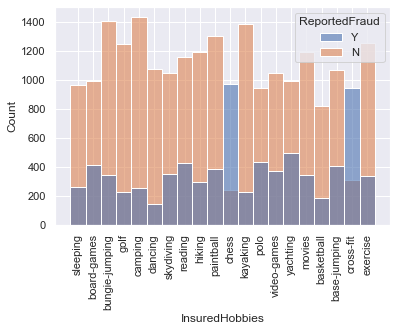

In [34]:
sns.histplot(data=df,x='InsuredHobbies',hue='ReportedFraud',alpha=0.6)
plt.xticks(rotation=90)
plt.show()
#InsuredHobbies: too many categories. But interestingly, majority of chess and cross-fit people are doing fraud.
#We'll turn this to binary - (chess or cross-fit): 1, others: 0

In [13]:
def cleanup(df):
    #cleanup of the data
    #country has only one value throughout. drop it
    #InsuredOccupation - too many categories. drop it
    todrop = ['Country','InsuredOccupation']
    df = df.drop(todrop,axis=1)
    df = df.dropna() #Insured Gender has 30 missing values.

    #Witnesses - drop the rows which say MISSINGVALUE only 46 out of 28836, turn it to int
    idx_drop = df['Witnesses'].loc[df['Witnesses']=='MISSINGVALUE'].index
    df = df.drop(idx_drop,axis=0)
    df['Witnesses'] = df['Witnesses'].astype(int)

    #AmountOfTotalClaim - drop the rows which say MISSEDDATA only 50 out of 28836, turn it to int
    idx_drop = df['AmountOfTotalClaim'].loc[df['AmountOfTotalClaim']=='MISSEDDATA'].index
    df = df.drop(idx_drop,axis=0)
    df['AmountOfTotalClaim'] = df['AmountOfTotalClaim'].astype(int)
    #in total we dropped 30+46+50 = 126 rows out of 28836

    #IncidentAddress - do text editing to remove 'Location ' in front of it and turn it into a int feature
    df['IncidentAddress'] = df['IncidentAddress'].replace(r'[Location ]','',regex=True).astype(int)
    
    #turning UmbrellaLimit into binary
    #UmbrellaLimit - total 28710 instances. 
    #20972 instances are 0, and remaining 7738 (27%) have a wide range (from -1e6 to 1e7)
    #the distribution of target is different for 0 and for >0.
    #68% no, 32% yes for != 0
    #75% no, 25% yes for = 0
    #Its better to turn this into a binary variable 0 : 0, >0 : 1

    idx_0 = df['UmbrellaLimit'].loc[df['UmbrellaLimit'] == 0].index
    idx_n0 = df['UmbrellaLimit'].loc[df['UmbrellaLimit'] != 0].index
    df['UmbrellaLimit'].loc[idx_0] = 0.
    df['UmbrellaLimit'].loc[idx_n0] = 1.
    
    #turning it into days since 1/1/2014
    df['DateOfIncident'] = pd.to_datetime(df['DateOfIncident'],format = '%Y-%m-%d')
    df['DateOfIncident'] = (df['DateOfIncident'] - pd.Timestamp('2014-01-01 00:00:00')).dt.components.days

    #turning this into days since 1/1/1989
    df['DateOfPolicyCoverage'] = pd.to_datetime(df['DateOfPolicyCoverage'],format = '%Y-%m-%d')
    df['DateOfPolicyCoverage'] = (df['DateOfPolicyCoverage'] - pd.Timestamp('1989-01-01 00:00:00')).dt.components.days 
    
    #location based categories
    #BIG QUESTION - how to encode these categorical columns
    #TypeOfIncident - 4 categories
    #TypeOfCollission - 4 categories
    #InsuredRelationship - 6 categories
    #AuthoritiesContacted - 5 categories
    #Lets just turn them to integers - otherwise too many features are increasing if we do OneHotEncoder

    df['InsurancePolicyState'] = df['InsurancePolicyState'].replace(r'[State]','',regex=True).astype(int)
    df['IncidentCity'] = df['IncidentCity'].replace(r'[City]','',regex=True).astype(int)
    df['IncidentState'] = df['IncidentState'].replace(r'[State]','',regex=True).astype(int)
    
    #SeverityOfIncident - 4 categories - can make this into a linear scale:
    #TrivialDamage:0,MinorDamage:1,MajorDamage:2,TotalLoss:4
    enc_sev = {'Trivial Damage':0,'Minor Damage':1,'Major Damage':2,'Total Loss':3}
    df['SeverityOfIncident'] = df['SeverityOfIncident'].replace(enc_sev)
    
    #PropertyDamage,PoliceReport - Yes:1.,?:0.5,No:0.
    enc_ter = {'YES':1.,'?':0.5,'NO':0.}
    df[['PropertyDamage','PoliceReport']] = df[['PropertyDamage','PoliceReport']].replace(enc_ter)
    
    #InsuredGender: MALE:0,FEMALE:1
    enc_gen = {'MALE':0.,'FEMALE':1.}
    df['InsuredGender'] = df['InsuredGender'].replace(enc_gen)
    
    #InsuredEducationLevel: 7 categories - turn this into linear
    #HighSchool:0, Associate:1, College: 2, Masters:3, JD and MD:4, PhD: 5
    enc_edu = {'High School':0.,'Associate':1.,'College':2.,'Masters':3.,'JD':4.,'MD':4.,'PhD':5.}
    df['InsuredEducationLevel'] = df['InsuredEducationLevel'].replace(enc_edu)
    
    #InsuredHobbies: too many categories. But interestingly, majority of chess and cross-fit people are doing fraud.
    #lets turn this to binary - (chess or cross-fit): 1, others: 0
    idx_cc = df.loc[(df['InsuredHobbies'] == 'chess') | (df['InsuredHobbies'] == 'cross-fit')].index
    idx_ncc = df.loc[(df['InsuredHobbies'] != 'chess') & (df['InsuredHobbies'] != 'cross-fit')].index
    
    df['InsuredHobbies'].loc[idx_cc] = 1.0
    df['InsuredHobbies'].loc[idx_ncc] = 0.0
    df['InsuredHobbies'] = df['InsuredHobbies'].astype(int)
    
    return df

In [14]:
df = cleanup(df)

C:\Users\dasab\AppData\Local\Temp\ipykernel_17380\484778044.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['UmbrellaLimit'].loc[idx_0] = 0.
C:\Users\dasab\AppData\Local\Temp\ipykernel_17380\484778044.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['UmbrellaLimit'].loc[idx_n0] = 1.
C:\Users\dasab\AppData\Local\Temp\ipykernel_17380\484778044.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InsuredHobbies'].loc[id

In [15]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='O').columns.tolist()
cat_cols.remove('ReportedFraud')

# Plotting the Data

N    0.730024
Y    0.269976
Name: ReportedFraud, dtype: float64



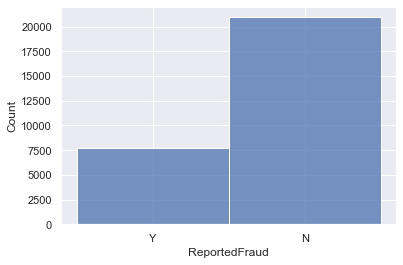

In [16]:
print(df['ReportedFraud'].value_counts()/df['ReportedFraud'].shape[0])
print()
sns.histplot(df['ReportedFraud'])
plt.show()
#not to terribly imbalanced

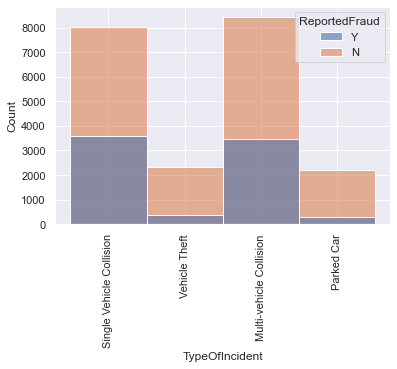

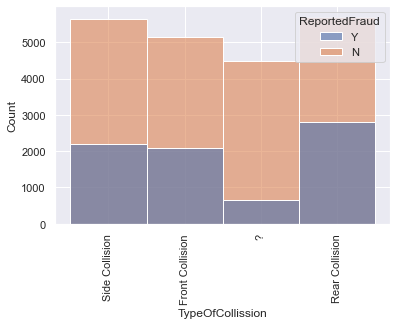

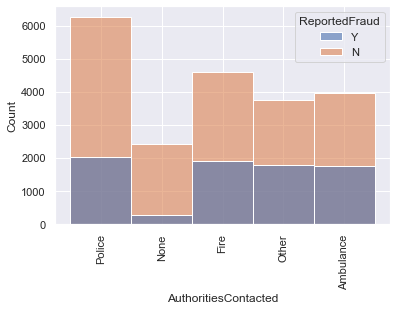

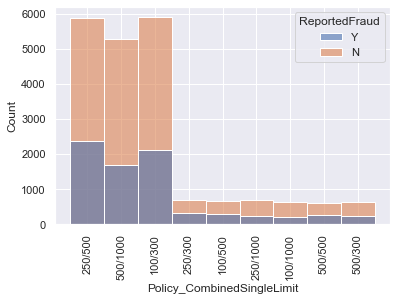

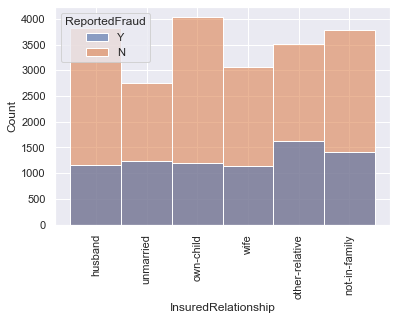

In [17]:
for i in cat_cols:
    sns.histplot(data=df,x=i,hue='ReportedFraud',alpha=0.6)
    plt.xlabel(i)
    plt.xticks(rotation=90)
    plt.show()
#we'll turn these to label encoded
#We see some class separation in TypeOfIncident (notice proportion of Y is lower in Vehicle Theft and Parked Car)
#Similarly in TypeOfIncident, ? has a lower proportion of Y compared to the other categories
#Same for AuthoritiesContacted, category None
#Not sure what Policy_CombinedSingleLimit means but there seems to be different porportions of Y and N in the 
#first 3 categories as compared to the remaining

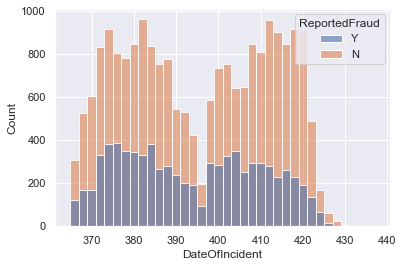

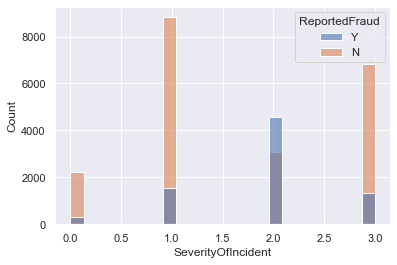

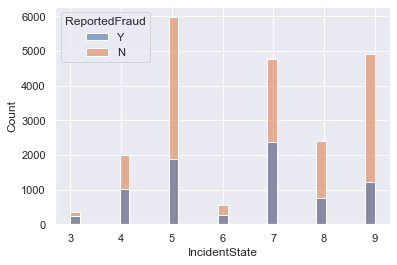

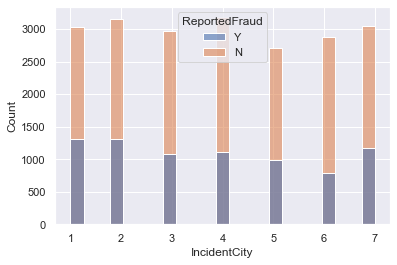

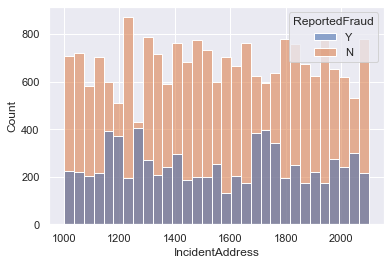

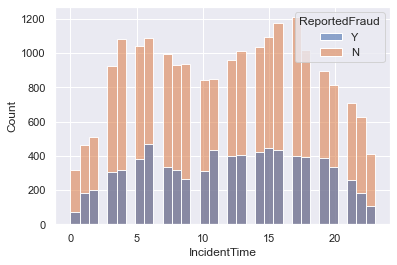

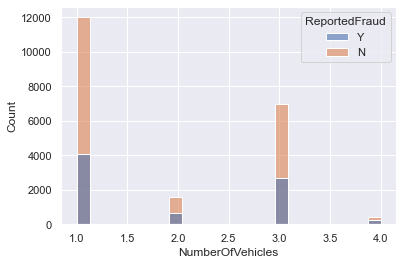

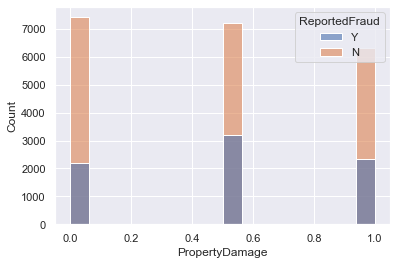

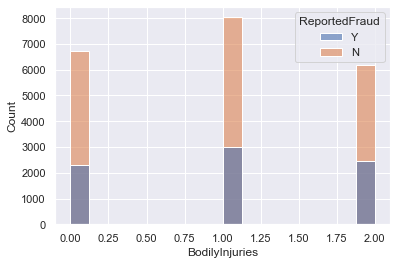

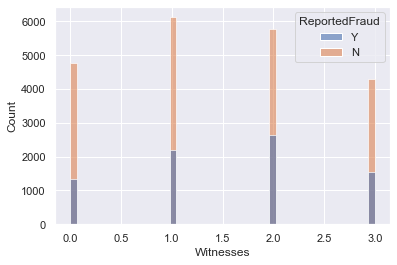

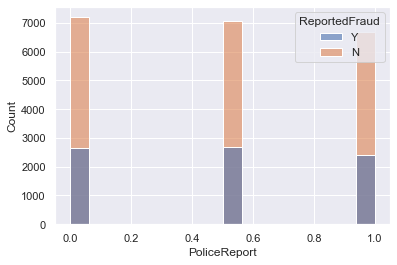

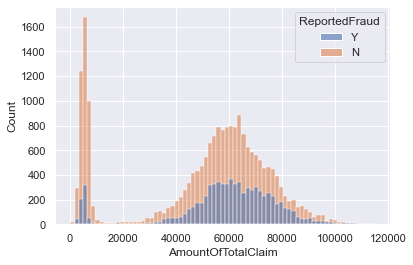

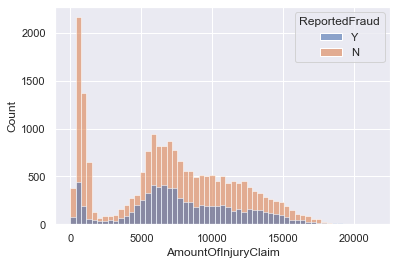

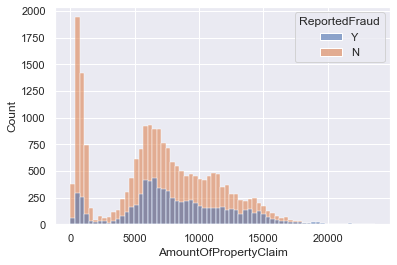

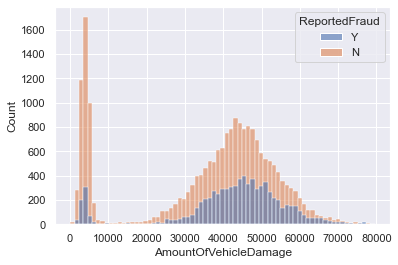

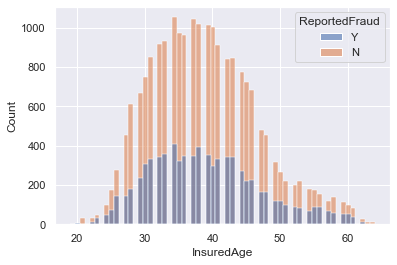

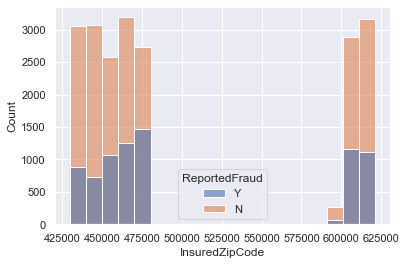

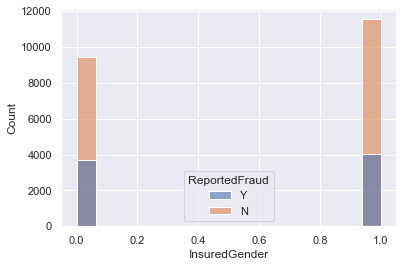

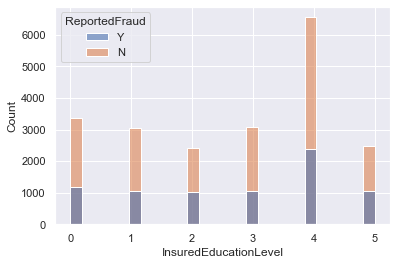

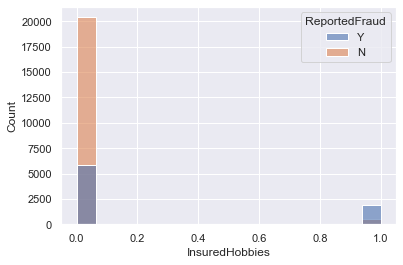

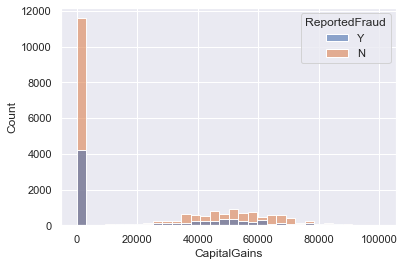

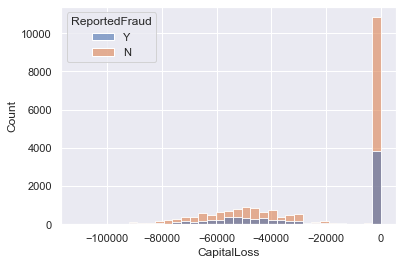

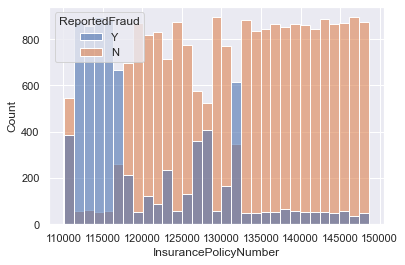

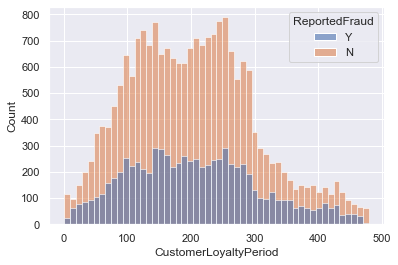

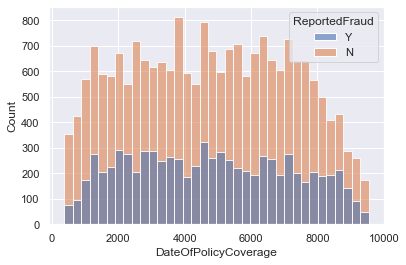

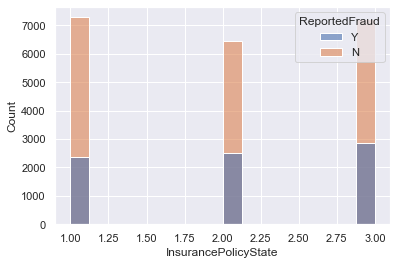

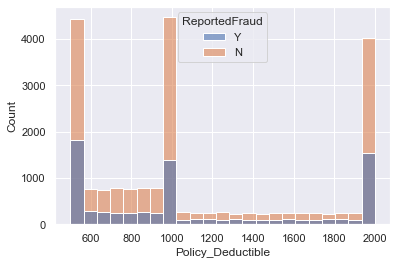

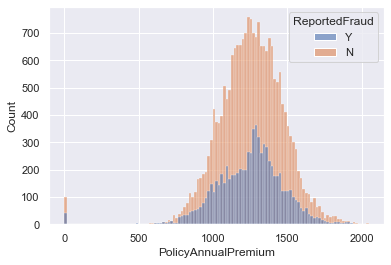

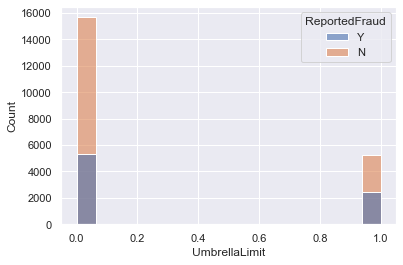

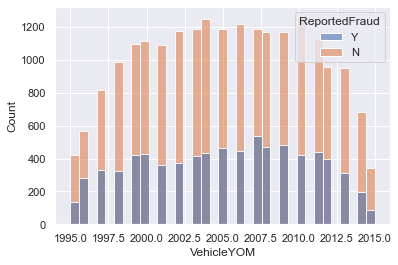

In [18]:
for i in num_cols:
    sns.histplot(data=df,x=i,hue='ReportedFraud',alpha=0.6)
    plt.xlabel(i)
    plt.show()
#InsurancePolicyNumber (surprisingly) show significant class separation
#SeverityOfIncident also shows flipping of proportions of Y and N for value 2 (which encodes for Major Damage)

# Preparing the Data for Models

In [19]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

#label encoder on cat_cols
le = list()
for i in cat_cols:
    enc = LabelEncoder()
    enc.fit(df[i])
    df[i] = enc.transform(df[i])
    le.append(enc)

In [20]:
df['ReportedFraud'] = df['ReportedFraud'].replace({'Y':1.0,'N':0.0}).astype(float)

In [21]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(df.drop('ReportedFraud',axis=1),df['ReportedFraud'],test_size=0.2,random_state=2)

In [22]:
scaler = MinMaxScaler()
scaler.fit(trainX)

def data_transform(X):
    return scaler.transform(X)

X_train = data_transform(trainX)
X_test = data_transform(testX)
y_train = trainY
y_test = testY
#our data is now ready for the models

# Model Fitting

In [24]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score

In [25]:
classifiers = [LogisticRegression(),SGDClassifier(),
               GaussianNB(), DecisionTreeClassifier(),
               LGBMClassifier(), CatBoostClassifier(verbose=False),XGBClassifier()]

scores = pd.DataFrame(columns=['Classifier','TestAccuracy','TrainAccuracy','TestRecall','TrainRecall'])

for i in classifiers:
    i.fit(X_train, y_train)
    y_pred_test = i.predict(X_test)
    y_pred_train = i.predict(X_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    train_acc = accuracy_score(y_train, y_pred_train)
    test_rec = recall_score(y_test,y_pred_test)
    train_rec = recall_score(y_train,y_pred_train)
    scores.loc[len(scores.index)] = [i.__class__.__name__,test_acc,train_acc,test_rec,train_rec]

C:\Users\dasab\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
scores.sort_values(by='TestRecall')

,Classifier,TestAccuracy,TrainAccuracy,TestRecall,TrainRecall
0,LogisticRegression,0.842215,0.842651,0.587150,0.585046
2,GaussianNB,0.835249,0.835859,0.633588,0.635378
1,SGDClassifier,0.828979,0.830634,0.638041,0.639586
3,DecisionTreeClassifier,0.868513,1.000000,0.771628,1.000000
4,LGBMClassifier,0.936956,0.940047,0.828880,0.828937
5,CatBoostClassifier,0.938871,0.944793,0.830789,0.842369
6,XGBClassifier,0.940439,0.964342,0.840967,0.895614


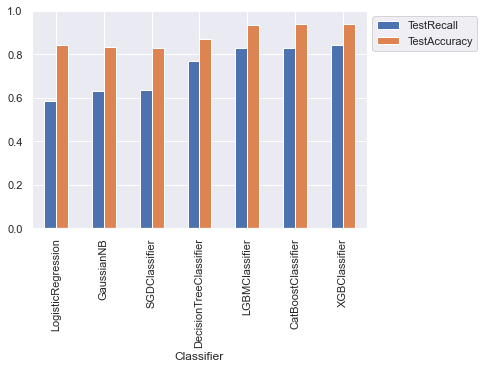

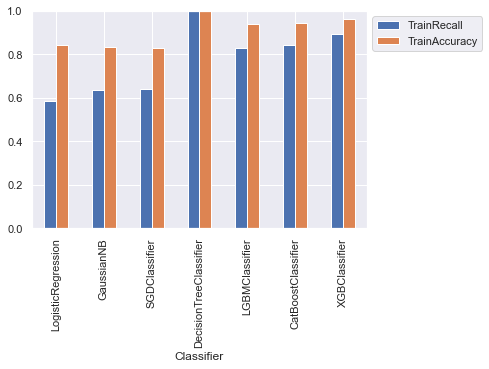

In [27]:
scores.sort_values(by='TestRecall').plot.bar(x='Classifier',y=['TestRecall','TestAccuracy'])
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

scores.sort_values(by='TestRecall').plot.bar(x='Classifier',y=['TrainRecall','TrainAccuracy'])
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [ ]:
#even without any tuning, XGB, Catboost and LGBM are performing decently.

# Feature Importance

In [28]:
def feature_imp(clf,featimp,n):
    print(clf)
    print("Top {} Features".format(n))
    top = np.flip(np.argsort(featimp)[-n:])
    topcols = trainX.columns[top].tolist()
    print(topcols)
    print()  
    return topcols

In [29]:
n = 10

xgb_feat = np.array(list(classifiers[6].get_booster().get_score(importance_type='gain').values())) 
xgb_top = feature_imp(scores['Classifier'].loc[6],xgb_feat,n)

cat_feat = classifiers[5].get_feature_importance()
cat_top = feature_imp(scores['Classifier'].loc[5],cat_feat,n)

lgbm_feat = classifiers[4].feature_importances_
lgbm_top = feature_imp(scores['Classifier'].loc[4],lgbm_feat,n)

#Our best model, XGB, has picked up InsuredHobbies as the second most important feature.

XGBClassifier
Top 10 Features
['InsurancePolicyNumber', 'InsuredHobbies', 'SeverityOfIncident', 'UmbrellaLimit', 'TypeOfCollission', 'CapitalLoss', 'InsuredRelationship', 'IncidentAddress', 'BodilyInjuries', 'Policy_Deductible']

CatBoostClassifier
Top 10 Features
['InsurancePolicyNumber', 'SeverityOfIncident', 'IncidentAddress', 'InsuredZipCode', 'DateOfPolicyCoverage', 'PolicyAnnualPremium', 'InsuredHobbies', 'AmountOfVehicleDamage', 'DateOfIncident', 'AmountOfInjuryClaim']

LGBMClassifier
Top 10 Features
['InsurancePolicyNumber', 'DateOfPolicyCoverage', 'PolicyAnnualPremium', 'IncidentAddress', 'AmountOfInjuryClaim', 'InsuredZipCode', 'SeverityOfIncident', 'AmountOfVehicleDamage', 'CustomerLoyaltyPeriod', 'AmountOfTotalClaim']



In [30]:
list(set(list(set(xgb_top).intersection(cat_top))).intersection(lgbm_top)) 
#common top features of all 3 

['InsurancePolicyNumber', 'IncidentAddress', 'SeverityOfIncident']

# Optimizing XGBoost

In [35]:
#We'll optimize XGBoost. These are the default hyper-paramters which fit to the training set
classifiers[6].get_params() 

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 12,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate':np.linspace(0.2,0.4,10),
              'n_estimators':[100,150,200]}

cv=5
xgb_gcv = GridSearchCV(XGBClassifier(),param_grid,cv=cv,
                       scoring='recall',n_jobs=-1)
xgb_gcv.fit(X_train,y_train)
y_pred = xgb_gcv.predict(X_test)
print(xgb_gcv.best_params_)
print('Recall score on test set:%s'
      %recall_score(y_test,y_pred))
print('Accuracy score on test set:%s'
      %accuracy_score(y_test,y_pred))

print("Score from un-optimized training:")
print(scores.loc[6])
#no significant change in scores
#I think we're better off with the default xgb model

C:\Users\dasab\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:38:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.22222222222222224, 'n_estimators': 150}
Recall score on test set:0.8409669211195929
Accuracy score on test set:0.9404388714733543
Score from un-optimized training:
Classifier       XGBClassifier
TestAccuracy          0.940439
TrainAccuracy         0.964342
TestRecall            0.840967
TrainRecall           0.895614
Name: 6, dtype: object
